In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()


In [ ]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

In [ ]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [ ]:
root_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [ ]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [ ]:
SIZE = 256

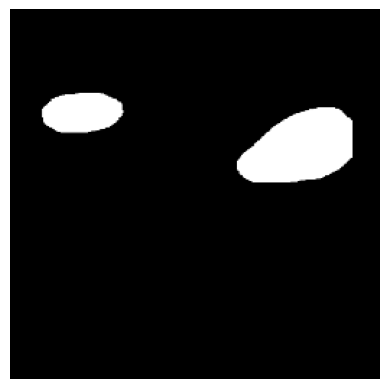

In [ ]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('../content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('../content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

In [ ]:
# Initialize lists to store image paths, mask paths, and class labels
image_paths = []
mask_paths = []
class_labels = []

# Iterate over each class directory
for idx, class_name in enumerate(classes):
    # Path to the class directory
    class_dir = os.path.join(root_path, class_name)

    # Get all mask paths in this class directory
    mask_files = glob(os.path.join(class_dir, '*_mask*.png'))  # Adjust as per mask file naming conventions

    # Extract corresponding image paths from mask paths
    for mask_path in mask_files:
        # Assuming the image file is named similarly to the mask file without '_mask' or with different mask identifiers
        img_path = mask_path.replace('_mask_1.png', '.png').replace('_mask.png', '.png')  # Adjust based on actual naming patterns

        # Append to lists
        image_paths.append(img_path)
        mask_paths.append(mask_path)
        class_labels.append(idx)  # Use class index as the label

# Now image_paths, mask_paths, and class_labels are populated and synchronized
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)
labels= to_categorical(class_labels, num_classes=3)

In [ ]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

In [ ]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [ ]:
from tensorflow.keras.callbacks import Callback
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

class ShowProgress(Callback):
    def __init__(self, model, images, masks, class_labels):
        super().__init__()
        self.model = model  # Assign the passed 'complete_model' to an instance variable
        self.images = images
        self.masks = masks
        self.class_labels = class_labels

    def on_epoch_end(self, epoch, logs=None):
        # Randomly select an image from the dataset for visualization
        id = np.random.randint(len(self.images))
        image = self.images[id]
        mask = self.masks[id]
        class_label = self.class_labels[id]

        # Model prediction for both mask and class
        pred_mask, pred_class = self.model.predict(image[np.newaxis, ...])

        # Visualization using GradCAM for classification decision explanation
        exp = Gradcam(self.model, model_modifier=None, clone=True)
        cam = exp(
            loss=lambda output: (output[np.argmax(pred_class)]),
            seed_input=image[np.newaxis, ...],
            layer_name='Attention4'  # Ensure this is a layer in your model
        )

        # Display the Grad-CAM heatmap
        heatmap = np.uint8(255 * normalize(cam))
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.title("Original Image")
        plt.imshow(image)  # Assuming you have a function to display images
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title("Original Mask")
        plt.imshow(mask, cmap='copper')  # Assuming mask is an image-like array
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask[0, ..., 0], cmap='copper')  # Assuming pred_mask is a single-channel mask
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title("GradCAM")
        plt.imshow(cam, cmap='jet')  # Display the GradCAM heatmap
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Optionally, print additional information
        if 'classification_output_accuracy' in logs:
            print(f"Epoch {epoch+1}: Classification Accuracy: {logs['classification_output_accuracy']:.2f}")

progress_callback = ShowProgress(complete_model, images, masks, class_labels)

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

gap = GlobalAveragePooling2D(name='global_average_pooling')(encoding)
dropout = Dropout(0.5, name='dropout')(gap)
classification_output = Dense(3, activation='softmax', name='classification_output')(dropout)


# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same', name='output_layer')(d4)
complete_model = Model(inputs=input_layer, outputs=[output_layer, classification_output])

# Compile the new model with separate loss functions for each output and combined metrics
complete_model.compile(
    optimizer='adam',
    loss={'output_layer': 'binary_crossentropy', 'classification_output': 'categorical_crossentropy'},
    metrics={'output_layer': ['accuracy', MeanIoU(num_classes=2)], 'classification_output': ['accuracy']}
)

# Print the model summary
complete_model.summary()
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint("DualOutputUNet_model.keras", save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1) , # Reduces learning rate when a metric has stopped improving
progress_callback
]



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Encoder1 (EncoderBlock)     ((None, 128, 128, 32),       10144     ['input_3[0][0]']             
                              (None, 256, 256, 32))                                               
                                                                                                  
 Encoder2 (EncoderBlock)     ((None, 64, 64, 64),         55424     ['Encoder1[0][0]']            
                              (None, 128, 128, 64))                                               
                                                                                            

Experimental Training

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming 'images' and 'masks' are your image and mask arrays respectively
# and 'class_labels' is a list of categorical labels for classification

# Convert class labels to one-hot encoding
class_labels_categorical = to_categorical(class_labels, num_classes=3)  # Adjust 'num_classes' as per your dataset

# Split data into training and validation sets
X_train, X_val, y_train_mask, y_val_mask, y_train_class, y_val_class = train_test_split(
    images, masks, class_labels_categorical, test_size=0.2, random_state=42)


In [ ]:
# Data Generators
# Define a simple image data generator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
class_datagen = ImageDataGenerator(**data_gen_args)  # No augmentation for class labels

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train_mask, augment=True, seed=seed)

In [ ]:

def combined_generator(image_gen, mask_gen, class_gen):
    while True:
        # Get the next batch from each generator
        x_img_batch, x_class_batch = next(image_gen)
        y_mask_batch = next(mask_gen)

        # Yield a combined batch (input, output)
        yield (x_img_batch, {'output_layer': y_mask_batch, 'classification_output': x_class_batch})

# Set up generators for training and validation
train_image_gen = image_datagen.flow(X_train, y_train_class, batch_size=8, seed=seed)
train_mask_gen = mask_datagen.flow(y_train_mask, batch_size=8, seed=seed)

val_image_gen = image_datagen.flow(X_val, y_val_class, batch_size=8, seed=seed)
val_mask_gen = mask_datagen.flow(y_val_mask, batch_size=8, seed=seed)

# Create combined generators
train_generator = combined_generator(train_image_gen, train_mask_gen, train_image_gen)
val_generator = combined_generator(val_image_gen, val_mask_gen, val_image_gen)

Epoch 1/50
79/79 [==============================] - 27s 347ms/step - loss: 1.2305 - output_layer_loss: 0.2299 - classification_output_loss: 1.0006 - output_layer_accuracy: 0.9185 - output_layer_mean_io_u_1: 0.4626 - classification_output_accuracy: 0.5635 - val_loss: 1.2641 - val_output_layer_loss: 0.2450 - val_classification_output_loss: 1.0191 - val_output_layer_accuracy: 0.9282 - val_output_layer_mean_io_u_1: 0.4670 - val_classification_output_accuracy: 0.5375
Epoch 2/50
79/79 [==============================] - 28s 354ms/step - loss: 1.1932 - output_layer_loss: 0.2212 - classification_output_loss: 0.9720 - output_layer_accuracy: 0.9187 - output_layer_mean_io_u_1: 0.4626 - classification_output_accuracy: 0.5841 - val_loss: 1.2005 - val_output_layer_loss: 0.2513 - val_classification_output_loss: 0.9492 - val_output_layer_accuracy: 0.9296 - val_output_layer_mean_io_u_1: 0.4679 - val_classification_output_accuracy: 0.5813
Epoch 3/50
79/79 [==============================] - 27s 341ms/step

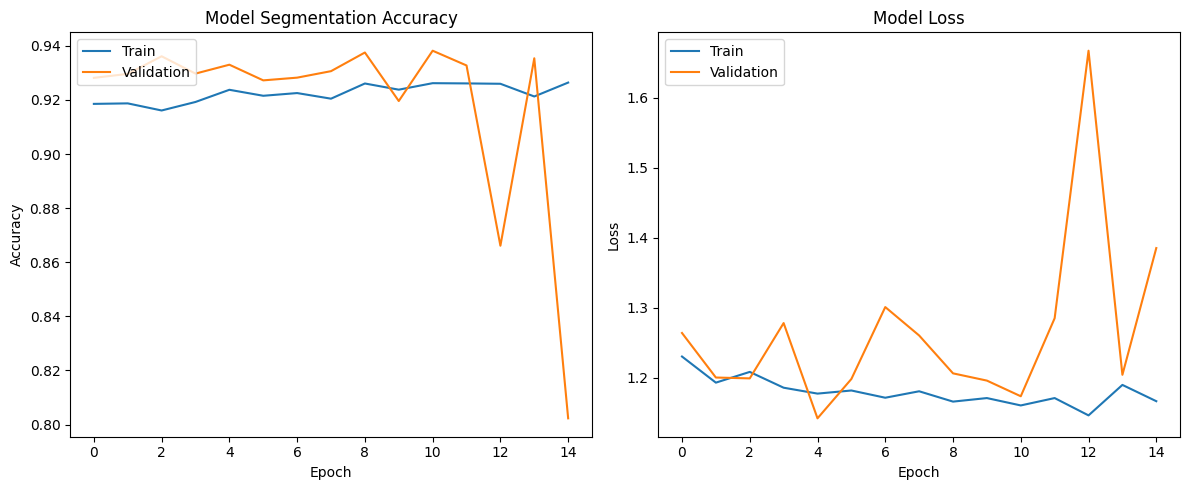

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Training
history = complete_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 8,
    validation_data=val_generator,
    validation_steps=len(X_val) // 8,
    epochs=50,  # Adjust the number of epochs as needed
    callbacks=callbacks
)

# Save the final trained model (optional if ModelCheckpoint is used)
complete_model.save("final_model.keras")

# Plot Training and Validation Accuracy and Loss
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training & validation accuracy values
    ax[0].plot(history.history['output_layer_accuracy'])
    ax[0].plot(history.history['val_output_layer_accuracy'])
    ax[0].set_title('Model Segmentation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)
